# Interpretability and performances of deep learning models in bathymetric inversion

## Importation of the modules

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from numpy.random import seed
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter
from tensorflow.keras.optimizers import Adam

In [2]:
os.chdir('/home/aurelien/Desktop/FCN_bathy')
os.getcwd()

'/home/aurelien/Desktop/FCN_bathy'

In [3]:
from src.Param import Param
from src.models.UnetModel import UNet
from src.evaluation.metric_functions import *
from src.executor.tf_init import start_tf_session
from src.utils import initialize_file_path, sorted_list_path
from src.verification.verif_functions import plot_predictions, predict_novel_data, plot_pred_uncertainty
from src.verification.verif_functions import averaged_pred, apply_black_patch, plot_output_generator

## 0. Initialization

In [4]:
# mode = 'gpu'
mode = 'cpu'
start_tf_session(mode)

# keras seed fixing
seed(42)
# tensorflow seed fixing
tf.random.set_seed(42)

case = 108 #110 #90
res_csv = pd.read_csv('trained_models/Results_test.csv')

params = Param('./configs/' + res_csv['Param_file'][case]).load()

train_input, train_target = initialize_file_path(params['Input']['DIR_NAME'], 'Train')
val_input, val_target = initialize_file_path(params['Input']['DIR_NAME'], 'Validation')
test_input, test_target = initialize_file_path(params['Input']['DIR_NAME'], 'Test')

Hyperparameters loaded OK.


## 1. Load the model

In [5]:
print(res_csv['Name'][case])
Trained_model = tf.keras.models.load_model(res_csv['Name'][case],
                                           custom_objects={'absolute_error': absolute_error,
                                                           'pred_min': pred_min,
                                                           'pred_max': pred_max},
                                           compile=False)

Trained_model.compile(optimizer=Adam(params['Train']['LR'], 0.5),
                      loss='mse',
                      metrics=[root_mean_squared_error,
                               absolute_error,
                               psnr,
                               ssim,
                               ms_ssim])

# Unet model for generator
Unet_model = UNet(params)

trained_models/Pix2pix_Data_ext_fil_2017_f32_b1_ep600_30-08-2022_19:21


2022-08-31 11:57:42.349450: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-31 11:57:42.349645: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Evaluation of the model
### On test set 

In [6]:
test_gen = Unet_model.data_generator('Test')
test_res = Trained_model.evaluate(test_gen)

2022-08-31 11:57:43.916144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-31 11:57:43.916475: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2496000000 Hz


63/63 [==============================] - 43s 652ms/step - loss: 0.4667 - root_mean_squared_error: 0.6691 - absolute_error: 0.5503 - psnr: 22.6689 - ssim: 0.7566 - ms_ssim: 0.9110


### On train set

In [7]:
train_gen = Unet_model.data_generator('Train_no_aug')
train_res = Trained_model.evaluate(train_gen)

370/370 [==============================] - 257s 696ms/step - loss: 0.1460 - root_mean_squared_error: 0.3585 - absolute_error: 0.2883 - psnr: 27.1979 - ssim: 0.8442 - ms_ssim: 0.9438


## 3. Predictions
### On test data

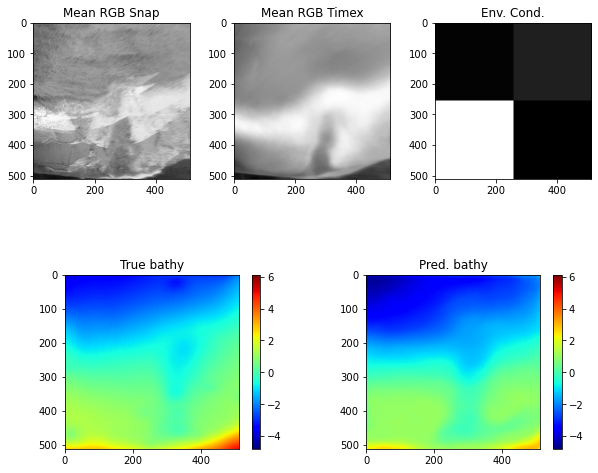

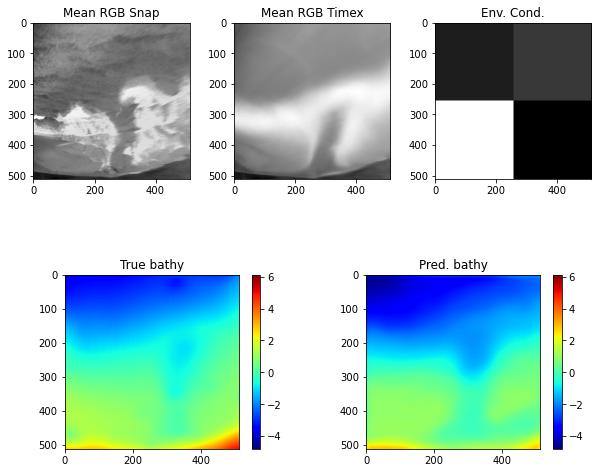

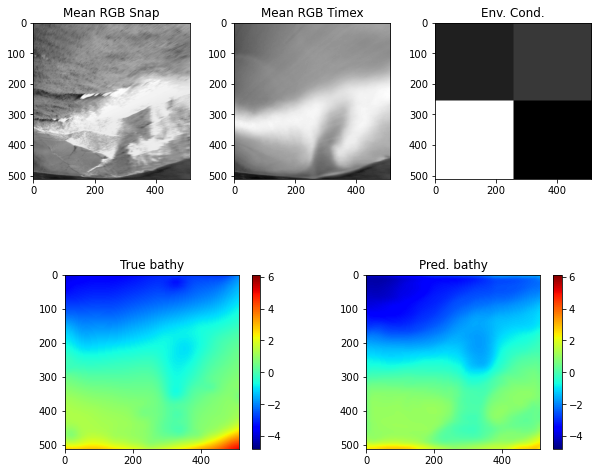

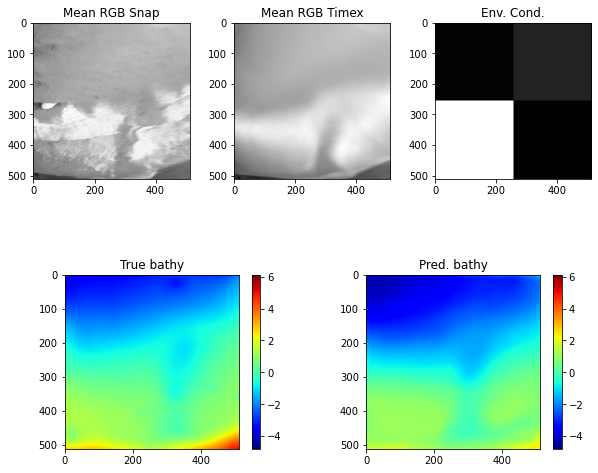

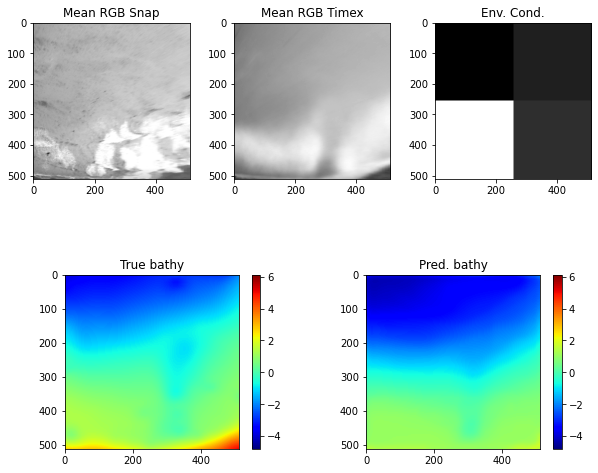

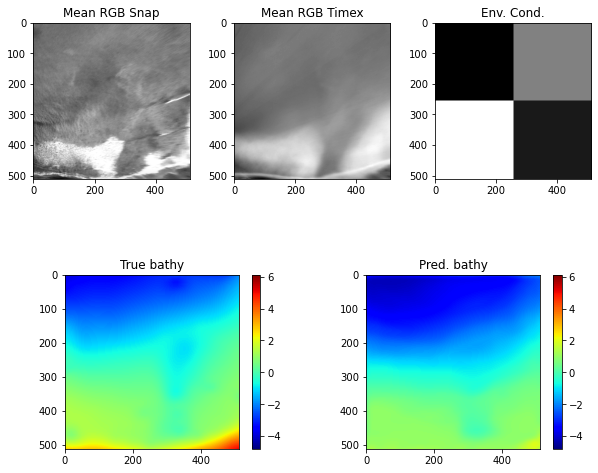

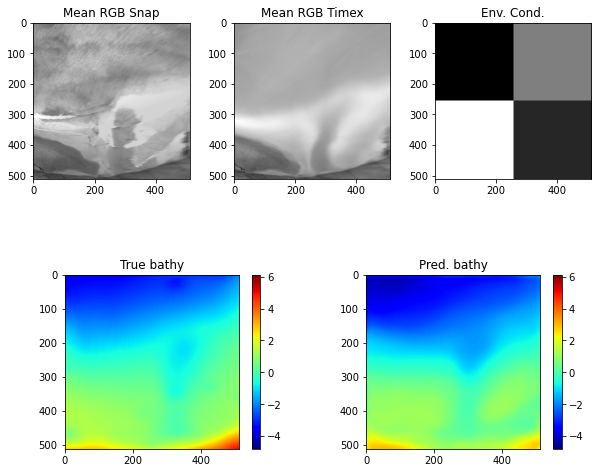

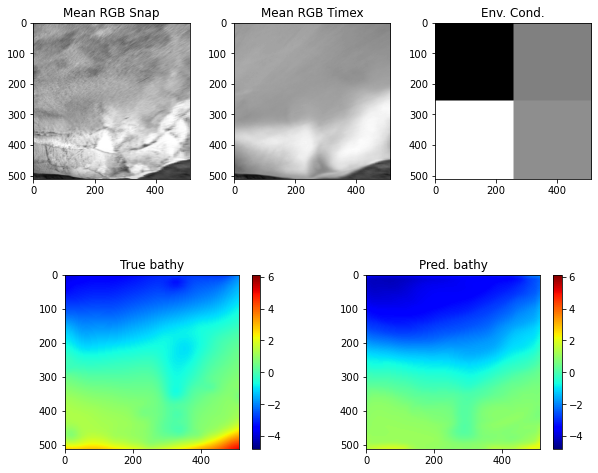

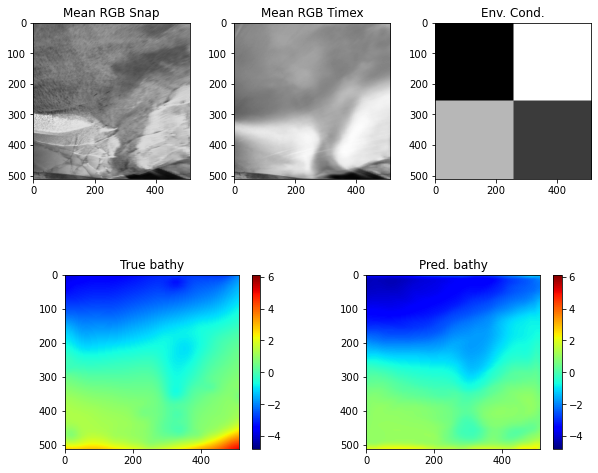

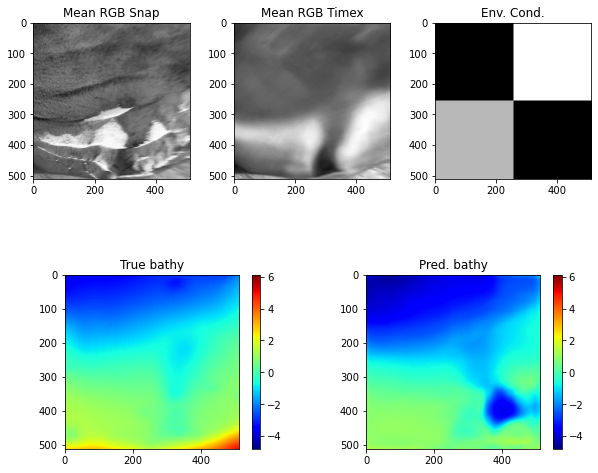

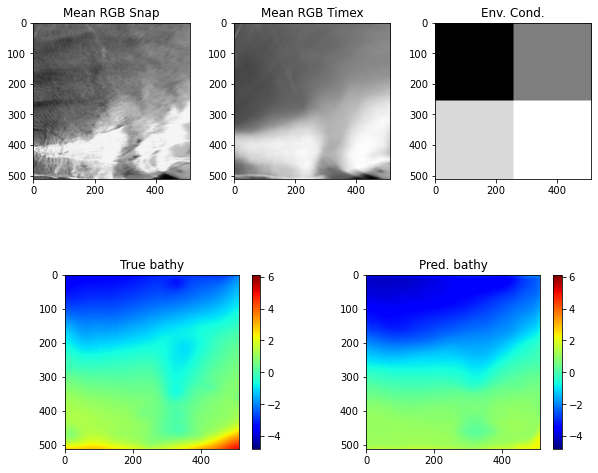

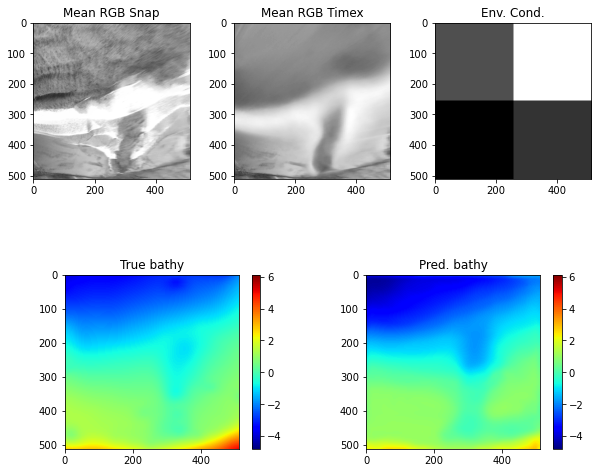

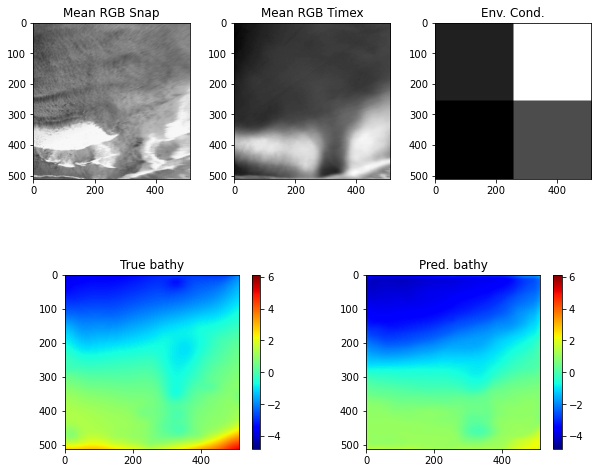

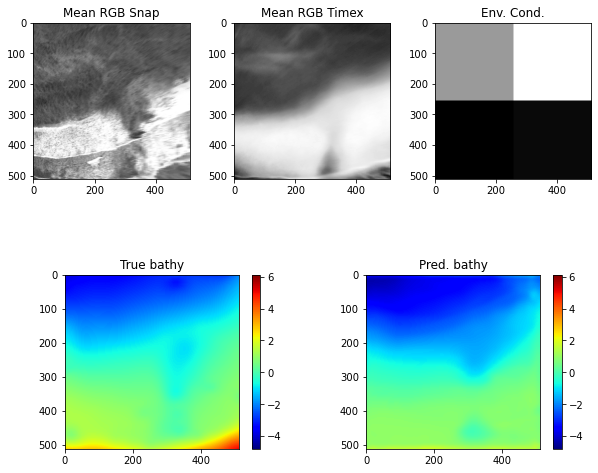

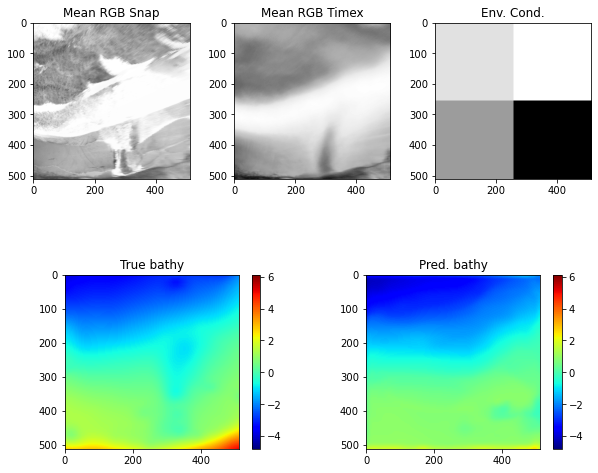

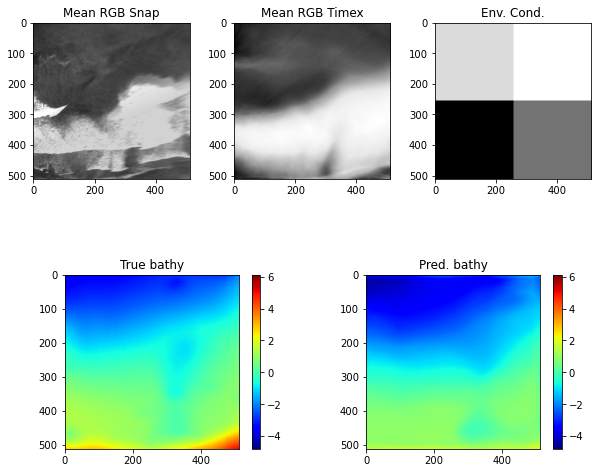

In [11]:
preds = Trained_model.predict(test_gen)

plot_predictions(test_generator=test_gen, predictions=preds, every_n=4)

### On novel data

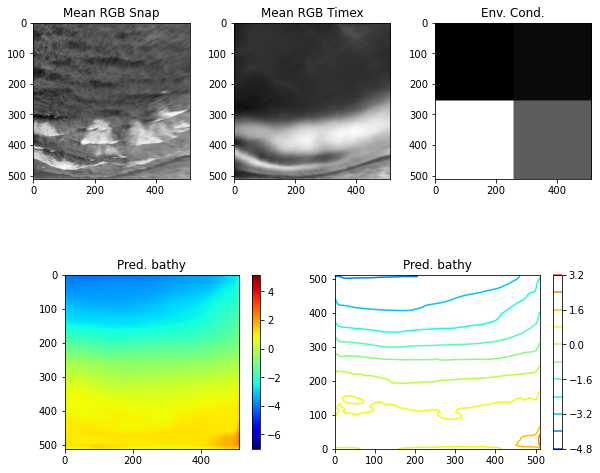

In [12]:
test_test = sorted_list_path("./data_CNN/Test_data/Test/Input/")
X_img = np.load(test_test[0])
pred_new = Trained_model.predict(np.expand_dims(X_img, axis=0))
predict_novel_data(X_img, pred_new)

## 4. Uncertainties and errors associated to predictions

In the same spirit as Collins et al (2020), we added drop-out and gaussian noise layers in the generator network (U-net). This two types of layers add randomness during the prediction process which means that varied predictions can be produced from one consistent input. The varied output are then averaged to obtain the final predicted depth map and areas with volatility / uncertainty can be identified. 

Here is an example for our case:

In [13]:
# Averaging the results of 5 predictions:
avg_pred, std_pred, err_pred = averaged_pred(test_gen, Trained_model, 5)

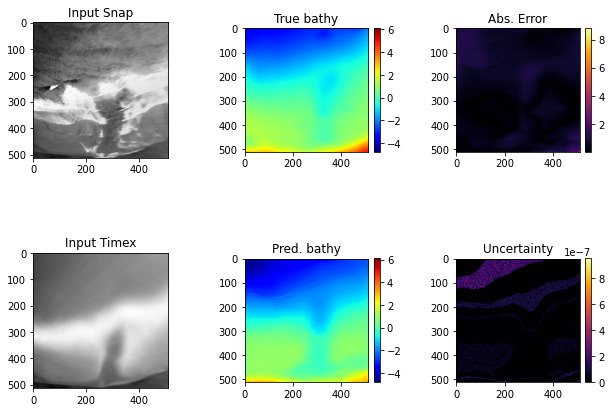

In [22]:
# Plot the image with index 12
plot_pred_uncertainty(5, test_gen, avg_pred, std_pred, err_pred)

We can note that the uncertainty of the model is close to 0. This can mean that the uncertainty is not working as expected or not really informative in our case. 

We confirm this hypothesis when we plot the uncertainty of the model versus the absolute error of the model as we see no correlations: 

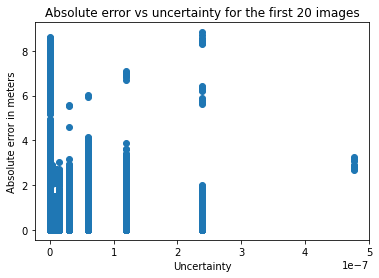

In [15]:
std_vec = np.array(std_pred)[:20, :, :].flatten()
err_vec = np.array(err_pred)[:20, :, :].flatten()

plt.scatter(x=std_vec, y=err_vec)
plt.xlabel("Uncertainty")
plt.ylabel("Absolute error in meters")
plt.title("Absolute error vs uncertainty for the first 20 images")
plt.show()

The model does not know when it does not know ! 

More investigations should be done on uncertainty estimation...

## 5. Activation maps

The visualization of activation maps is hepful to determine what are the features selected by the network to perform a certain prediction.


When dissipitation is visible on the snap and timex, the network seems to rely more on timex and snap channel and it activates more on the wave dissipation areas:

**Input**:

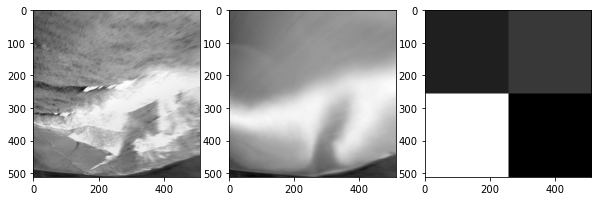

In [17]:
item = 8
input_0 = test_gen.__getitem__(item)[0]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(6, 9)
gs.update(wspace=0.8, hspace=0.5)
ax1 = fig.add_subplot(gs[:6, 0:3])
ax1.imshow(np.uint8(input_0.squeeze()[:, :, 0]*255), cmap='gray')
ax2 = fig.add_subplot(gs[:6 , 3:6])
ax2.imshow(np.uint8(input_0.squeeze()[:, :, 1]*255), cmap='gray')
ax2 = fig.add_subplot(gs[:6 , 6:])
ax2.imshow(np.uint8(input_0.squeeze()[:, :, 2]*255), cmap='gray')
plt.show()


**Associated activation maps**:

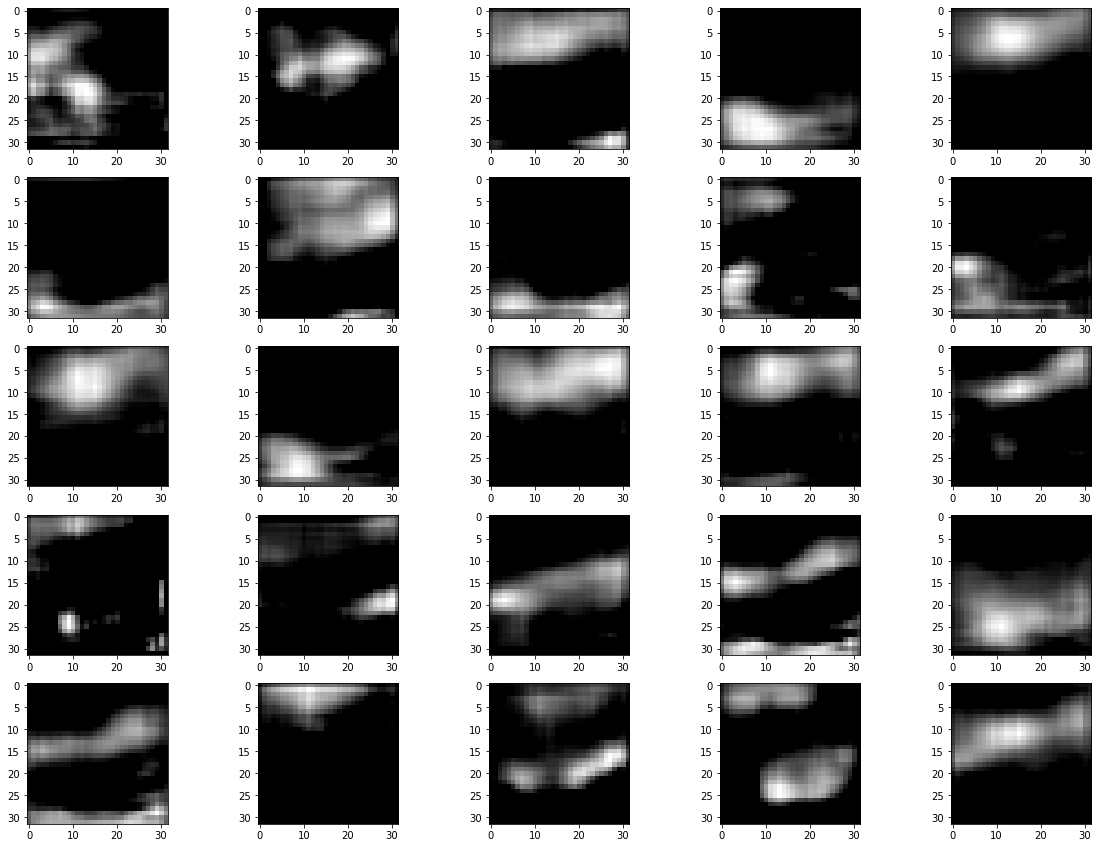

In [17]:
model = tf.keras.Model(inputs=Trained_model.inputs,
                       outputs=Trained_model.layers[31].output)
features = model.predict(input_0)

fig = plt.figure(figsize=(20, 15))
for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
plt.show()

 ## 6. Occlusion map

In [ ]:
img = input_0[0]
true_0 = test_gen.__getitem__(item)[1]

pred_0 = Trained_model.predict(input_0)
PATCH_SIZE = 32
sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_black_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_img = Trained_model.predict(np.array([patched_image]))[0]

        confidence = float(absolute_error(true_0, predicted_img)/absolute_error(true_0, pred_0))

        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence

im = plt.imshow(gaussian_filter(sensitivity_map, 5), cmap='jet')
plt.colorbar(im,  fraction=0.046, pad=0.04)
plt.show()

## 7. Performances analysis 

### Performance metrics

We are using RMSE, MAE as classical metrics (pixel to pixel) for regression tasks. We also use Structural similarity index (SSIM) and Multi-scale Structural similarity index (MS-SSIM) which are measuring the structure similarity between two images (closer to one the better).

### Training vs Test set performances

The performances on the train set are:

In [19]:
metrics = ['mse', 'rmse', 'mae', 'psnr', 'ssim', 'ms_ssim']
{metrics[i]: train_res[i] for i in range(len(metrics))}

{'mse': 0.15604934096336365,
 'rmse': 0.37566787004470825,
 'mae': 0.2983691990375519,
 'psnr': 26.653696060180664,
 'ssim': 0.8645669221878052,
 'ms_ssim': 0.9484013319015503}

The performances on the test set are:

In [20]:
{metrics[i]: test_res[i] for i in range(len(metrics))}

{'mse': 0.3562304675579071,
 'rmse': 0.5611799359321594,
 'mae': 0.4297861158847809,
 'psnr': 24.983001708984375,
 'ssim': 0.7340714335441589,
 'ms_ssim': 0.8896476626396179}

There is a significative gap of performance between performances on train and test set. Gathering more data could reduce this gap.

### Computing the metrics on each image and associating the environmental conditions 

In [21]:
def calculate_metrics(true, pred):
    return([root_mean_squared_error(true, pred).numpy(),
            absolute_error(true, pred).numpy(),
            psnr(true, pred).numpy()[0],
            ssim(true, pred).numpy()[0],
            ms_ssim(true, pred).numpy()[0]])


true = np.stack([ test_gen.__getitem__(i)[1] for i in range(test_gen.__len__())], axis=0)
X = np.stack([test_gen.__getitem__(i)[0][:,:,:, :2].squeeze() for i in range(test_gen.__len__())], axis=0)

true = list(map(lambda x: np.round(x, 1), true))
X = list(map(lambda x: np.round(x, 2), X))

mean_snap = list(map(lambda x: np.round(np.median(x)*255, 2), X))

acc_array = np.array(list(map(lambda x, y: calculate_metrics(x, np.expand_dims(y,2)), true, avg_pred)))
acc_array = pd.DataFrame(acc_array, columns=('rmse', 'mae', 'pnsr', 'ssim', 'ms_ssim'))
acc_array['m_snap'] = mean_snap

acc_array['Date'] = list(map(lambda x: os.path.basename(x)[:-4], test_input))
# acc_array['Date'] = pd.to_datetime(acc_array['Date'], format="%Y-%m-%d %H_%M_%S")
acc_array['Date'] = pd.to_datetime(acc_array['Date'], format="%Y-%m-%d %H:%M:%S")

tide_wave_cond = pd.read_csv('data_CNN/Data_processed/Meta_df.csv')[['Date', 'bathy', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']]
tide_wave_cond['Date'] = pd.to_datetime(tide_wave_cond['Date'], format="%Y-%m-%d %H:%M:%S")

acc_array = pd.merge(acc_array, tide_wave_cond, on='Date', how='inner').drop_duplicates('rmse', ignore_index=True)

acc_array['rip'] = 0
acc_array.loc[acc_array['bathy'].isin( ['2017-03-27', '2018-01-31']), 'rip'] = 1

Save or not this array :

In [22]:
#acc_array.to_csv('data_CNN/Results/Accuracy_data_ext_fil_2017_p2p.csv')
# acc_array = pd.read_csv('data_CNN/Results/Accuracy_data_ext_fil_2017_p2p.csv')

### Performances depending on bathymetric surveys (test set)

We can see that the performances in terms of RMSE differ depending on the bathymetric survey: 

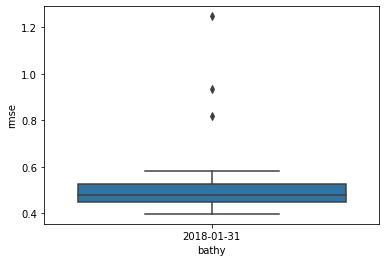

In [23]:
boxplot = sns.boxplot(y='rmse', x='bathy', data = acc_array)

It is the same for all the metrics: 

In [24]:
acc_array.groupby('bathy')[['rmse', 'mae', 'ssim', 'ms_ssim']].mean()

,rmse,mae,ssim,ms_ssim
bathy,,,,
2018-01-31,0.519024,0.390965,0.750563,0.903408


The performances are worse when we try to predict rip structures (2017-03-27 and 2018-01-31)

### Do the environmental conditions differ between bathymetric surveys? 

First let's investigate if the environmental conditions could explain the difference in performances for the bathymetric survey with rip structures (2017-03-27 and 2018-01-31):

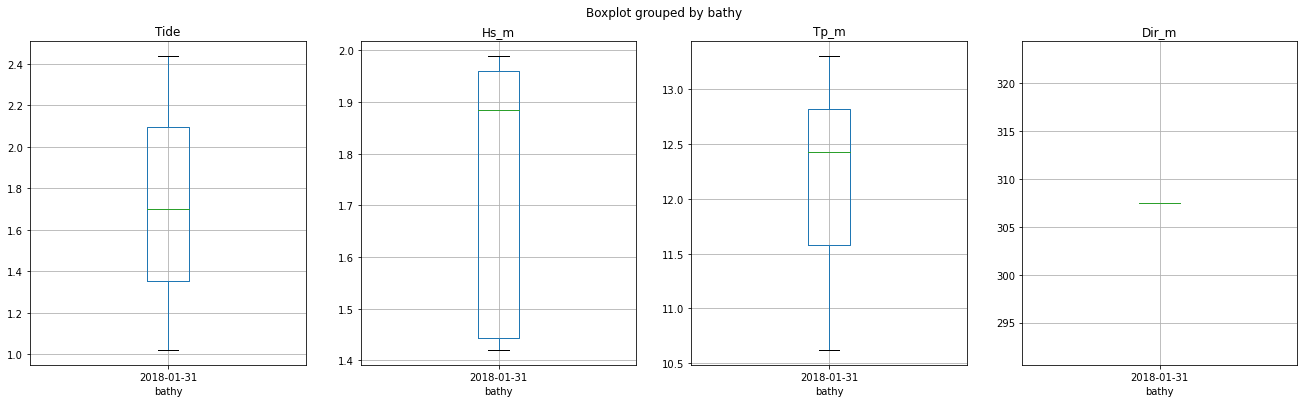

In [25]:
var_cond = ['Tide', 'Hs_m', 'Tp_m', 'Dir_m']
fig, axs = plt.subplots(1,4, figsize=(22, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i, var in  enumerate(var_cond):
     acc_array.boxplot(var, 'bathy', ax = axs[i])

We see similar tide conditions but the wave height is lower for the 2017-03-27 survey while the wave period is lower for the 2018-01-31 survey.

### Correlation between performances and environmental conditions

#### Including all surveys

We see that tide is positively correlated with RMSE while wave height is negatively correlated: 

<AxesSubplot:>

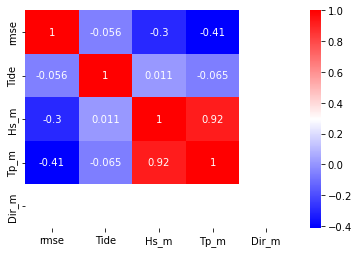

In [26]:
sns.heatmap(acc_array[['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

#### For surveys with rip current
##### 2017-03-27
We see that tide is positively correlated with RMSE while wave height is negatively correlated: 

/home/aurelien/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/aurelien/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot:>

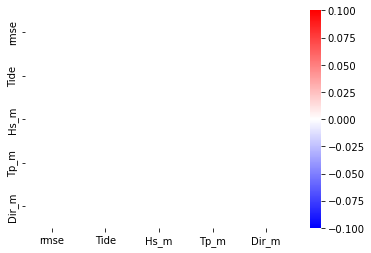

In [27]:
sns.heatmap(acc_array[acc_array['bathy'].isin(['2017-03-27'])][['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

##### 2018-01-31
We see that tide is positively correlated (high correlation coefficient) with RMSE while wave height and period are negatively correlated: 

<AxesSubplot:>

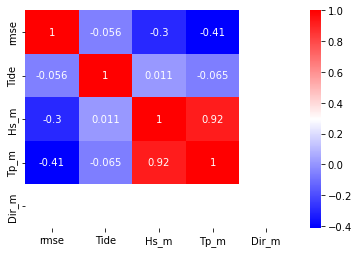

In [28]:
sns.heatmap(acc_array[acc_array['bathy'].isin(['2018-01-31'])][['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

### Tide vs cGAN performances 
We can plot the tide level vs RMSE performance to see their statistical relationship: 

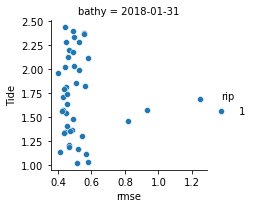

In [29]:
g = sns.FacetGrid(acc_array, col='bathy', hue="rip")
g.map_dataframe(sns.scatterplot, y='Tide', x='rmse', ci=None)
g.add_legend()

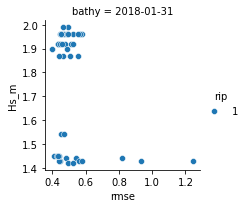

In [30]:
g = sns.FacetGrid(acc_array, col='bathy', hue="rip")
g.map_dataframe(sns.scatterplot, y='Hs_m', x='rmse', ci=None)
g.add_legend()

Higher tide levels seem to decrease the performance of the model.


### Tide and wave height vs cGAN performances 


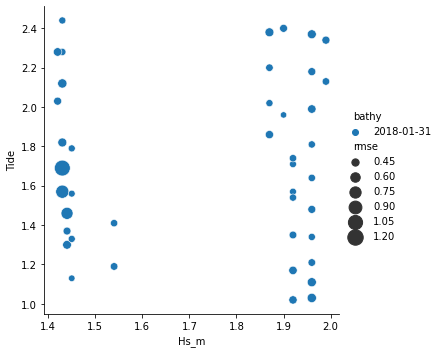

In [31]:
sns.relplot( y='Tide', x='Hs_m', hue="bathy", size = "rmse", sizes=(40, 250), data=acc_array)

We can see from this graph that the lower RMSE are located on the bottom right part of the graph which correspond to tide level below 3 meters with significant wave height above 1.2 meters. The performances seem to decrease when we go away from these conditions 

### Relationships between accurate prediction (RMSE < 0.4m) and environmental conditions


#### For all bathy

<AxesSubplot:xlabel='Acc', ylabel='Tide'>

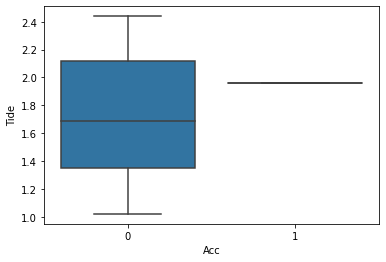

In [32]:
acc_array['Acc'] = 0
acc_array.loc[acc_array['rmse'] < 0.4, 'Acc'] = 1
acc_array['Acc'].value_counts()
sns.boxplot(y = 'Tide', x = 'Acc', data = acc_array)

<AxesSubplot:xlabel='Acc', ylabel='Hs_m'>

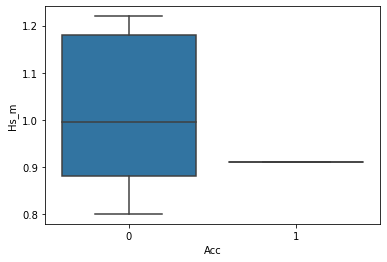

In [48]:
sns.boxplot(y = 'Hs_m', x = 'Acc', data = acc_array)

When we compare accurate predtictions (prediction with RMSE < 0.4m) vs non accurate prediction (RMSE>0.4m), we clearly see differences in terms of tide and wave conditions. The tide levels are lower for the accurate prediction  while significant wave height is higher.

#### For bathy with rip

We can perform the same analysis and restrict ourself to the bathymetric survey with a rip current;

<AxesSubplot:xlabel='Acc', ylabel='Tide'>

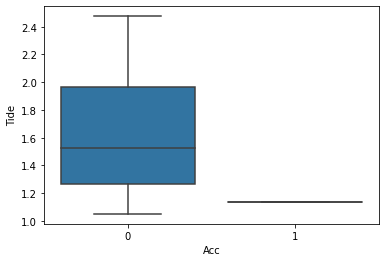

In [49]:
rip_bathy = acc_array[acc_array['rip'] == 1]
sns.boxplot(y = 'Tide', x = 'Acc', data = rip_bathy)

<AxesSubplot:xlabel='Acc', ylabel='Hs_m'>

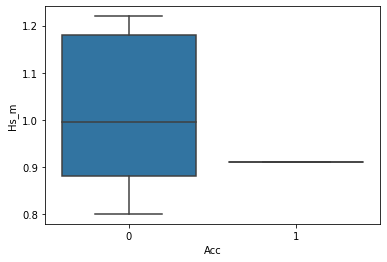

In [50]:
sns.boxplot(y = 'Hs_m', x = 'Acc', data = rip_bathy)

Here again the differences are clear: accurate predictions are made during low tide level and higher wave heights.

### Performances including all conditions vs optimal conditions 

We can now compare the performance of all conditions vs the optimal conditions that seem to be Tide < 3 meters and wave height > 1.1 meters:

In [51]:
acc_array[['rmse', 'mae', 'ssim', 'ms_ssim']].mean()

rmse       0.586531
mae        0.474494
ssim       0.785009
ms_ssim    0.918831
dtype: float32

In [55]:
sub_select = acc_array[(acc_array['Tide'] < 1.75) & (acc_array['Hs_m'] > 1.1)]
sub_select[['rmse', 'mae', 'ssim', 'ms_ssim']].mean()

rmse       0.497239
mae        0.384495
ssim       0.820120
ms_ssim    0.938540
dtype: float32